In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import Markdown, display

# Datasets
from aif360.datasets import StandardDataset

# from PhysionetDataset.py import PhysionetDataset.py
# Dataset = PhysionetDataset.py


# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [3]:
target_folder = "MoreFavoredProtectedAttributes"
prefix_folder = "MoreFavored"

In [4]:
#Physionet Dataset
#https://physionet.org/content/heart-failure-zigong/1.2/
np.random.seed(1)

default_mappings = {
    'label_maps': [{1.0: '1'}],
    'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}]
}



filepath = r'C:\Users\sujin\Documents\College\PhD_Project\Project/EditedData/'+ target_folder+'/heart_failure_'+ prefix_folder+'_NoCol.csv'
        
filepath2 = r'C:\Users\sujin\Documents\College\PhD_Project\Project/EditedData/'+ target_folder+'/heart_failure_'+ prefix_folder+'.csv'

df2 = pd.read_csv(filepath2)
df2.columns

class PhysionetDataset(StandardDataset):

    def __init__(self, label_name='return.to.emergency.department.within.6.months',
                 favorable_classes=[1],
                 protected_attribute_names=['gender'],
                 privileged_classes=[[1]],
                 instance_weights_name=None,
                 categorical_features=['DestinationDischarge', 'admission.ward', 'admission.way',
                                       "occupation", "discharge.department", "visit.times",
                                       "type.of.heart.failure", "NYHA.cardiac.function.classification",
                                       'Killip.grade', "ageCat", "type.II.respiratory.failure", "consciousness",
                                       "respiratory.support.", "oxygen.inhalation", "outcome.during.hospitalization"],
                 features_to_keep=[], features_to_drop=["inpatient.number"],
                 na_values=[], custom_preprocessing=None,
                 metadata=default_mappings):


        column_names = df2.columns
        try:
            df = pd.read_csv(filepath, header=None, names=column_names,
                             na_values=na_values)
            display(df)
            
        except IOError as err:
            print("IOError: {}".format(err))
            print("To use this class, please download the following files:")
            print("\n\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data")
            print("\thttps://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc")
            print("\nand place them, as-is, in the folder:")
            print("\n\t{}\n".format(os.path.abspath(os.path.join(
                os.path.abspath(__file__), '..', '..', 'data', 'raw', 'german'))))
            import sys
            sys.exit(1)

        super(PhysionetDataset, self).__init__(df=df, label_name=label_name,
                                               favorable_classes=favorable_classes,
                                               protected_attribute_names=protected_attribute_names,
                                               privileged_classes=privileged_classes,
                                               instance_weights_name=instance_weights_name,
                                               categorical_features=categorical_features,
                                               features_to_keep=features_to_keep,
                                               features_to_drop=features_to_drop, na_values=na_values,
                                               custom_preprocessing=custom_preprocessing, metadata=metadata)


In [5]:
# 3.1. Load data & create splits for learning/validating/testing model¶


(dataset_orig_train, dataset_orig_val, dataset_orig_test) = PhysionetDataset().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_train.unprivileged_protected_attributes[sens_ind]]

privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_train.privileged_protected_attributes[sens_ind]]


def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes,
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


describe(dataset_orig_train, dataset_orig_val, dataset_orig_test)

metric_orig_train = BinaryLabelDatasetMetric(
    dataset_orig_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_train)

print(explainer_orig_panel19_train.disparate_impact())

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,...,glutamyltranspeptidase,glutamic.pyruvic.transaminase,alkaline.phosphatase,total.bilirubin,total.bile.acid,total.protein,low.density.lipoprotein.cholesterol,triglyceride,high.density.lipoprotein.cholesterol,ageCat
0,0,762205,Home,Others,NonEmergency,UrbanResident,Cardiology,1,1,36.0,...,216.0,1196.0,118.0,37.1,24.3,71.7,3.45,0.64,1.22,"(69,79]"
1,1,782956,Home,GeneralWard,NonEmergency,UrbanResident,GeneralWard,1,1,36.3,...,50.0,27.0,58.0,40.5,7.6,58.4,1.01,0.54,1.21,"(79,89]"
2,2,758441,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,1,36.0,...,76.0,18.0,66.0,12.1,4.7,63.6,3.09,0.91,1.21,"(69,79]"
3,3,801155,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,1,36.9,...,121.0,48.0,141.0,20.8,4.4,77.9,3.18,1.23,1.19,"(69,79]"
4,4,865139,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,2,0,36.3,...,26.0,22.0,123.0,53.2,8.2,66.9,1.89,0.74,0.52,"(79,89]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,1051,799225,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,1,36.7,...,24.0,24.0,77.0,14.4,5.9,58.0,1.45,0.50,1.23,"(69,79]"
1052,1052,769113,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,0,42.0,...,29.0,9.0,56.0,21.2,4.7,66.9,1.45,1.17,0.81,"(79,89]"
1053,1053,809271,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,1,36.2,...,98.0,68.0,147.0,12.5,12.7,48.4,1.56,1.15,0.95,"(69,79]"
1054,1054,762608,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,1,36.4,...,24.0,29.0,77.0,35.7,4.9,70.1,0.91,0.86,0.94,"(69,79]"


#### Training Dataset shape

(528, 130)


#### Validation Dataset shape

(316, 130)


#### Test Dataset shape

(212, 130)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['Unnamed: 0', 'gender', 'body.temperature', 'pulse', 'respiration', 'map', 'weight', 'height', 'BMI', 'myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease', 'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease', 'connective.tissue.disease', 'peptic.ulcer.disease', 'diabetes', 'moderate.to.severe.chronic.kidney.disease', 'hemiplegia', 'malignant.lymphoma', 'solid.tumor', 'liver.disease', 'AIDS', 'eye.opening', 'movement', 'fio2', 'acute.renal.failure', 'left.ventricular.end.diastolic.diameter.LV', 'creatinine.enzymatic.method', 'urea', 'uric.acid', 'glomerular.filtration.rate', 'cystatin', 'monocyte.ratio', 'lymphocyte.count', 'mean.hemoglobin.volume', 'mean.hemoglobin.concentration', 'mean.platelet.volume', 'basophil.count', 'eosinophil.count', 'hemoglobin', 'platelet.distribution.width', 'platelet.hematocrit', 'neutrophil.count', 'D.dimer', 'international.normalized.ratio', 'activated.partial.thromboplastin.time', 'thrombin.time',

In [6]:
# 3.2. Learning a Logistic Regression (LR) classifier on original data¶
# 3.2.1. Training LR model on original data

dataset = dataset_orig_train
display(dataset)
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

               instance weights   features                      \
                                           protected attribute   
                                Unnamed: 0              gender   
instance names                                                   
530                         1.0      530.0                 0.0   
453                         1.0      453.0                 1.0   
925                         1.0      925.0                 1.0   
521                         1.0      521.0                 1.0   
839                         1.0      839.0                 1.0   
...                         ...        ...                 ...   
625                         1.0      625.0                 0.0   
879                         1.0      879.0                 0.0   
29                          1.0       29.0                 1.0   
39                          1.0       39.0                 0.0   
504                         1.0      504.0                 1.0   

         

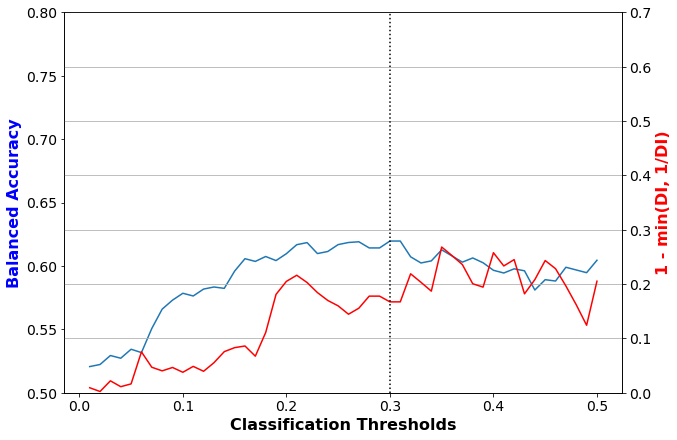

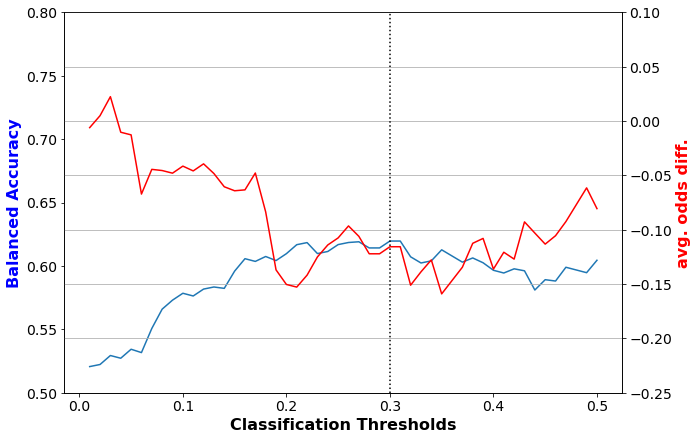

Validation Scores:
Threshold corresponding to Best balanced accuracy: 0.3000
Best balanced accuracy: 0.6196
Corresponding 1-min(DI, 1/DI) value: 0.1673
Corresponding average odds difference value: -0.1156
Corresponding statistical parity difference value: -0.0985
Corresponding equal opportunity difference value: -0.2239
Corresponding Theil index value: 0.1863


In [7]:
# 3.2.2. Validating LR model on original data¶

from collections import defaultdict


def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
            dataset, dataset_pred,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                       + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_orig,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)
    plt.show()
    
    
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1 / disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))


print("Validation Scores:")
describe_metrics(val_metrics, thresh_arr)

In [8]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Reweighing¶

#4.1. Transform data¶
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.3000
Best balanced accuracy: 0.5743
Corresponding 1-min(DI, 1/DI) value: 0.3030
Corresponding average odds difference value: -0.1763
Corresponding statistical parity difference value: -0.1660
Corresponding equal opportunity difference value: -0.2515
Corresponding Theil index value: 0.2387
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


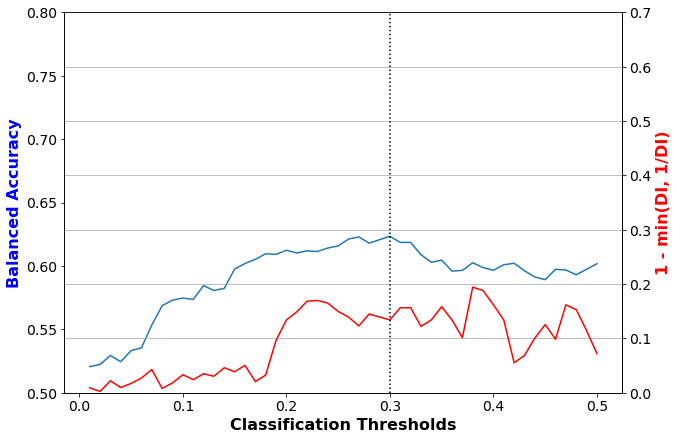

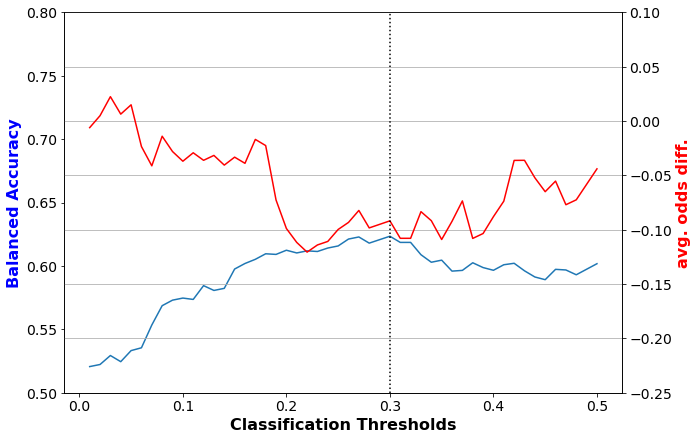

Threshold corresponding to Best balanced accuracy: 0.3000
Best balanced accuracy: 0.6234
Corresponding 1-min(DI, 1/DI) value: 0.1340
Corresponding average odds difference value: -0.0918
Corresponding statistical parity difference value: -0.0789
Corresponding equal opportunity difference value: -0.1763
Corresponding Theil index value: 0.1826


In [9]:
#4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing¶

#4.2.1. Training LR model after reweighing¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after reweighing¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [10]:
#4.2.3. Testing LR model after reweighing¶
lr_transf_metrics = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])


Threshold corresponding to Best balanced accuracy: 0.3000
Best balanced accuracy: 0.5743
Corresponding 1-min(DI, 1/DI) value: 0.3030
Corresponding average odds difference value: -0.1763
Corresponding statistical parity difference value: -0.1660
Corresponding equal opportunity difference value: -0.2515
Corresponding Theil index value: 0.2387


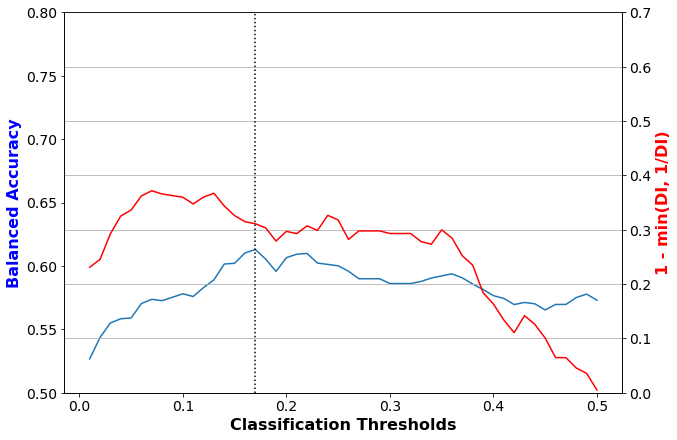

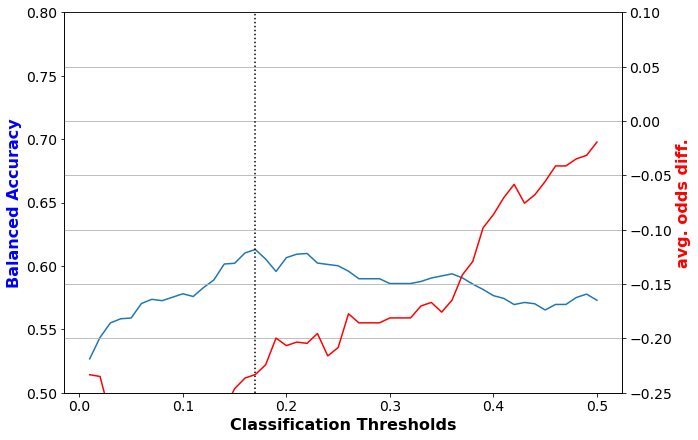

Threshold corresponding to Best balanced accuracy: 0.1700
Best balanced accuracy: 0.6130
Corresponding 1-min(DI, 1/DI) value: 0.3110
Corresponding average odds difference value: -0.2332
Corresponding statistical parity difference value: -0.2124
Corresponding equal opportunity difference value: -0.3616
Corresponding Theil index value: 0.1557


In [11]:
#5. Bias mitigation using in-processing technique - Prejudice Remover (PR)¶

#5.1.1. Training a PR model
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig = model.fit(dataset)

#5.1.2. Validating PR model¶

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)


In [12]:
#5.1.3. Testing PR model¶

dataset = dataset_orig_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1700
Best balanced accuracy: 0.5438
Corresponding 1-min(DI, 1/DI) value: 0.2652
Corresponding average odds difference value: -0.1849
Corresponding statistical parity difference value: -0.1706
Corresponding equal opportunity difference value: -0.2621
Corresponding Theil index value: 0.2122


In [13]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Reweighing,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Prejudice Remover,,0.543835,-0.184907,0.734833,-0.170585,-0.262121,0.212236


In [14]:
#Disparate Impact Remover

from aif360.algorithms.preprocessing import DisparateImpactRemover


In [15]:
#3.2.3. Testing LR model on original data¶

print("Test Scores:")
lr_orig_metrics = test(dataset=dataset_orig_test,
                       model=lr_orig,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

#4. Bias mitigation using pre-processing technique - Disparate Impact Remover¶

#4.1. Transform data¶


di = DisparateImpactRemover(repair_level=1.0)
dataset_transf_train = di.fit_transform(dataset_orig_train)
dataset_transf_test = di.fit_transform(dataset_orig_test)

#Metrics for transformed data

metric_transf_train = BinaryLabelDatasetMetric(
        dataset_transf_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_train = MetricTextExplainer(metric_transf_train)

print(explainer_transf_train.disparate_impact())

Test Scores:
Threshold corresponding to Best balanced accuracy: 0.3000
Best balanced accuracy: 0.5743
Corresponding 1-min(DI, 1/DI) value: 0.3030
Corresponding average odds difference value: -0.1763
Corresponding statistical parity difference value: -0.1660
Corresponding equal opportunity difference value: -0.2515
Corresponding Theil index value: 0.2387
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9064285714285715


Threshold corresponding to Best balanced accuracy: 0.2400
Best balanced accuracy: 0.6185
Corresponding 1-min(DI, 1/DI) value: 0.1074
Corresponding average odds difference value: -0.0850
Corresponding statistical parity difference value: -0.0661
Corresponding equal opportunity difference value: -0.2033
Corresponding Theil index value: 0.1726


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


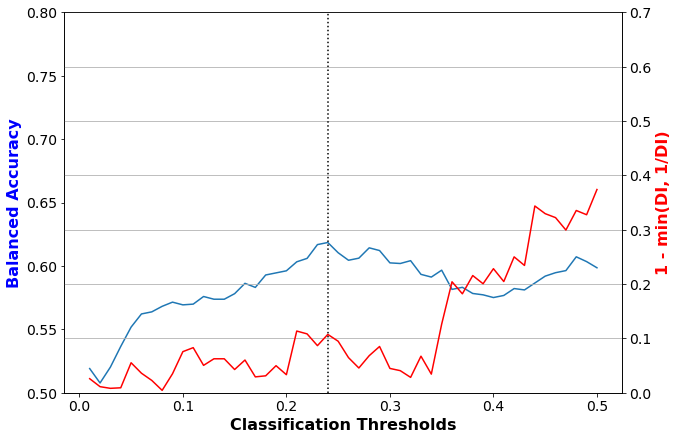

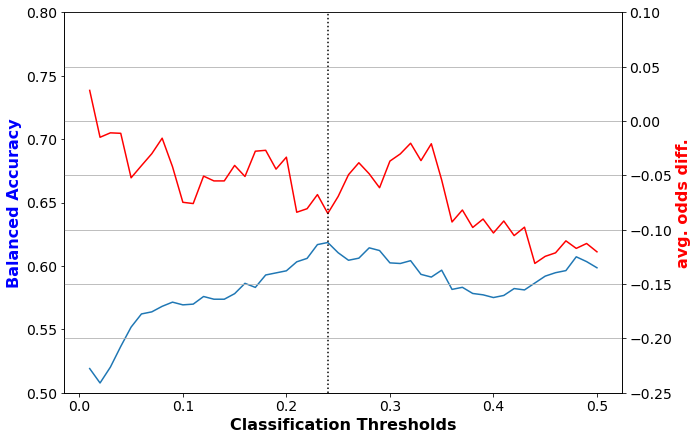

In [16]:
#4.2.1. Training LR model after Disparate Impact Remover¶
dataset = dataset_transf_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#4.2.2. Validating LR model after Disdparate impact Remover¶


thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_val,
                   model=lr_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

describe_metrics(val_metrics, thresh_arr)

In [17]:
#Test LR DIR Model

lr_metrics_DIR = test(dataset=dataset_orig_test,
                         model=lr_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])
describe_metrics(lr_metrics_DIR, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2400
Best balanced accuracy: 0.5875
Corresponding 1-min(DI, 1/DI) value: 0.4409
Corresponding average odds difference value: -0.2885
Corresponding statistical parity difference value: -0.2724
Corresponding equal opportunity difference value: -0.3924
Corresponding Theil index value: 0.2114


In [18]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Reweighing,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Prejudice Remover,,0.543835,-0.184907,0.734833,-0.170585,-0.262121,0.212236
Disparate Impact Remover,Logistic Regression,0.587486,-0.288520,0.559138,-0.272380,-0.392424,0.211358


In [19]:
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()


# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.035393
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.056746


In [20]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.035393
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.056746


In [21]:
#Learn plan classifier without debiasing
# Load post-processing algorithm that equalizes the odds
# Learn parameters with debias set to False
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

plain_model.fit(dataset_orig_train)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.718186
epoch 1; iter: 0; batch classifier loss: 0.652107
epoch 2; iter: 0; batch classifier loss: 0.647843
epoch 3; iter: 0; batch classifier loss: 0.641848
epoch 4; iter: 0; batch classifier loss: 0.569438
epoch 5; iter: 0; batch classifier loss: 0.664248
epoch 6; iter: 0; batch classifier loss: 0.607724
epoch 7; iter: 0; batch classifier loss: 0.613763
epoch 8; iter: 0; batch classifier loss: 0.596500
epoch 9; iter: 0; batch classifier loss: 0.628983
epoch 10; iter: 0; batch classifier loss: 0.595228
epoch 11; iter: 0; batch classifier loss: 0.611189
epoch 12; iter: 0; batch classifier loss: 0.592474
epoch 13; iter: 0; batch classifier loss: 0.562558
epoch 14; iter: 0; batch classifier loss: 0.627811
epoch 15; iter: 0; batch classifier loss: 0.574992
epoch 16; iter: 0; batch classifier loss: 0.584748
epoch 17; iter: 0; batch cla

In [22]:
# Apply the plain model to test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [23]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Statisticsal parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

metrics_AD = defaultdict(list,
            {'bal_acc': [bal_acc_nodebiasing_test],
             'avg_odds_diff': [classified_metric_nodebiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_nodebiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_nodebiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_nodebiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_nodebiasing_test.theil_index()]})


#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.088484
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.134800


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.622642
Test set: Balanced classification accuracy = 0.577335
Test set: Average odds difference = -0.149442
Test set: Disparate impact = 0.519008
Test set: Statisticsal parity difference = -0.134800
Test set: Equal opportunity difference = -0.243939
Test set: Theil_index = 0.353931


In [24]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            pr_orig_metrics, lr_metrics_DIR, metrics_AD]
debias = pd.Series([''] + ['Reweighing']
                 + ['Prejudice Remover'] + ["Disparate Impact Remover"] + ["Adversarial Debias"],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*2 + [''] + ["Logistic Regression"] + ["No Debias"],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Reweighing,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Prejudice Remover,,0.543835,-0.184907,0.734833,-0.170585,-0.262121,0.212236
Disparate Impact Remover,Logistic Regression,0.587486,-0.288520,0.559138,-0.272380,-0.392424,0.211358
Adversarial Debias,No Debias,0.577335,-0.149442,0.519008,-0.134800,-0.243939,0.353931


In [25]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_train)


epoch 0; iter: 0; batch classifier loss: 0.751360; batch adversarial loss: 0.608119
epoch 1; iter: 0; batch classifier loss: 0.665831; batch adversarial loss: 0.638487
epoch 2; iter: 0; batch classifier loss: 0.609027; batch adversarial loss: 0.641278
epoch 3; iter: 0; batch classifier loss: 0.606112; batch adversarial loss: 0.654431
epoch 4; iter: 0; batch classifier loss: 0.585432; batch adversarial loss: 0.661216
epoch 5; iter: 0; batch classifier loss: 0.605472; batch adversarial loss: 0.668796
epoch 6; iter: 0; batch classifier loss: 0.642668; batch adversarial loss: 0.668760
epoch 7; iter: 0; batch classifier loss: 0.595630; batch adversarial loss: 0.670292
epoch 8; iter: 0; batch classifier loss: 0.625022; batch adversarial loss: 0.662631
epoch 9; iter: 0; batch classifier loss: 0.689777; batch adversarial loss: 0.665416
epoch 10; iter: 0; batch classifier loss: 0.594422; batch adversarial loss: 0.663662
epoch 11; iter: 0; batch classifier loss: 0.647786; batch adversarial loss:

In [26]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [27]:
# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())



display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())





display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())

metrics_AD2 = defaultdict(list,
            {'bal_acc': [bal_acc_debiasing_test],
             'avg_odds_diff': [classified_metric_debiasing_test.average_odds_difference()],
             'disp_imp': [classified_metric_debiasing_test.disparate_impact()],
             'stat_par_diff': [classified_metric_debiasing_test.statistical_parity_difference()],
             'eq_opp_diff': [classified_metric_debiasing_test.equal_opportunity_difference()],
             'theil_ind': [classified_metric_debiasing_test.theil_index()]})

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.088484
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.134800


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = 0.698278
Test set: Difference in mean outcomes between unprivileged and privileged groups = 0.594441


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.622642
Test set: Balanced classification accuracy = 0.577335
Test set: Disparate impact = 0.519008
Test set: Equal opportunity difference = -0.243939
Test set: Average odds difference = -0.149442
Test set: Theil_index = 0.353931


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.570755
Test set: Balanced classification accuracy = 0.528147
Test set: Disparate impact = 6.184848
Test set: Equal opportunity difference = 0.518182
Test set: Average odds difference = 0.583267
Test set: Theil_index = 0.381937


In [28]:
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, lr_transf_metrics,
            lr_metrics_DIR,pr_orig_metrics, metrics_AD, metrics_AD2]
debias = pd.Series(['None'] + ['Reweighing']
                 + ["Disparate Impact Remover"] + ['Prejudice Remover']+ ["Adversarial Debias"]*2,
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression']*4 + ["GD(No Debias)"] +["GD(Debased)"],
                name='Classifier')
final_df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])
final_df

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Reweighing,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Disparate Impact Remover,Logistic Regression,0.587486,-0.288520,0.559138,-0.272380,-0.392424,0.211358
Prejudice Remover,Logistic Regression,0.543835,-0.184907,0.734833,-0.170585,-0.262121,0.212236
Adversarial Debias,GD(No Debias),0.577335,-0.149442,0.519008,-0.134800,-0.243939,0.353931
Adversarial Debias,GD(Debased),0.528147,0.583267,6.184848,0.594441,0.518182,0.381937


In [29]:
final_df.to_pickle("HeartFailure_Results_"+ prefix_folder+"_P_Pickle")
pickle = pd.read_pickle("HeartFailure_Results_"+ prefix_folder+"_P_Pickle")
pickle

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
None,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Reweighing,Logistic Regression,0.574289,-0.176307,0.697040,-0.165953,-0.251515,0.238734
Disparate Impact Remover,Logistic Regression,0.587486,-0.288520,0.559138,-0.272380,-0.392424,0.211358
Prejudice Remover,Logistic Regression,0.543835,-0.184907,0.734833,-0.170585,-0.262121,0.212236
Adversarial Debias,GD(No Debias),0.577335,-0.149442,0.519008,-0.134800,-0.243939,0.353931
Adversarial Debias,GD(Debased),0.528147,0.583267,6.184848,0.594441,0.518182,0.381937


In [30]:
("HeartFailure_Results_"+ prefix_folder+"_P_Pickle")

'EditedData/MoreFavoredProtectedAttributes/HeartFailure_Results_MoreFavored_P_Pickle'